# Tumor Detection with Deep residual learning and UNet

## Liberaries Installation

In [38]:
!pip install pydicom

In [39]:
!pip install scikit-plot

In [40]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 28.1 MB/s 


## Drive Mount


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




```
# This is formatted as code
```

## Import Liberaries

In [42]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow.compat.v1 as tf
from tensorflow import keras
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [43]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF




```
# This is formatted as code
```

# Access Dataset Path

In [44]:
masks_path = os.path.join('/content/drive/MyDrive/Dataset/train','masks')
training_path = os.path.join('/content/drive/MyDrive/Dataset/train','patients')

## Image Visualization funtions

> Indented block



In [45]:
def displayimage(*args,**kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

# Image Preprocessing Functions

In [46]:
def imagenormalization(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

# Image Data Aqcuisition and Preprocessing



In [47]:
class DataGen(keras.utils.Sequence):


    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def image_preprocessing(self,image_sliced):   
        image_sliced[image_sliced>1200] = 0
        image_sliced   = np.clip(image_sliced, -100, 400)
        image_sliced = imagenormalization(image_sliced)

    
        image_sliced = image_sliced * 255
        image_sliced = image_sliced.astype('uint8')
        image_sliced = cv2.equalizeHist(image_sliced)
        image_sliced = imagenormalization(image_sliced)
        return image_sliced
        
    def __load__(self, id_name):
        patient_id = id_name.split('_')
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = self.image_preprocessing(dicom_image.pixel_array)
        image = imagenormalization(image)
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        
        mask = pydicom.dcmread(os.path.join(mask_path,patient_id[0]+'_liver' , id_name)).pixel_array
        mask = mask/255.0
        mask = np.clip(mask, 0, 1)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask[:, :, np.newaxis]
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []
    
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [48]:
image_size =  256
train_path = "/content/drive/MyDrive/Dataset/train"
batch_size = 8
epochs = 50
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]
print(len(train_ids))

585


# Image Slicing Function

In [49]:
def step1_preprocess_img_slice(img_slc):  
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = imagenormalization(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = imagenormalization(img_slc)
    return img_slc


In [50]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape,y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


## Image visalization with Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


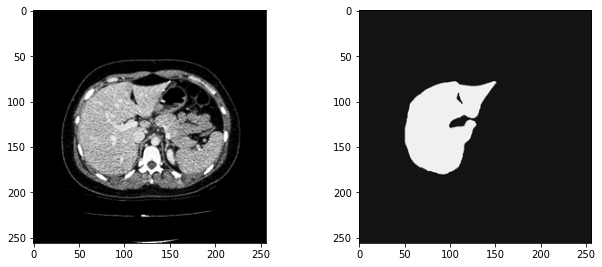

In [51]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

# Convolutional Neural Network Implimentation

1.   List item
2.   List item



## Model Configration

In [52]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [53]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [54]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [55]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_180 (Conv2D)            (None, 256, 256, 16  448         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_168 (Batch  (None, 256, 256, 16  64         ['conv2d_180[0][0]']             
 Normalization)                 )                                                           

# Model Training

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:459: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  return f(*args)
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/base.py:573: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  _add_elements_to_collection(self.updates, tf.compat.v1.GraphKeys.UPDATE_OPS)


73/73 [==============================] - 569s 7s/step - loss: 0.8212 - acc: 0.8747 - dice_coef: 0.0865 - val_loss: 0.8642 - val_acc: 0.0723 - val_dice_coef: 0.1358
Epoch 2/50
73/73 [==============================] - 146s 2s/step - loss: 0.5525 - acc: 0.9409 - dice_coef: 0.4475 - val_loss: 0.9972 - val_acc: 0.9035 - val_dice_coef: 0.0028
Epoch 3/50
73/73 [==============================] - 144s 2s/step - loss: 0.5378 - acc: 0.9635 - dice_coef: 0.4622 - val_loss: 0.8669 - val_acc: 0.9076 - val_dice_coef: 0.1331
Epoch 4/50
73/73 [==============================] - 144s 2s/step - loss: 0.6571 - acc: 0.9571 - dice_coef: 0.3429 - val_loss: 0.7782 - val_acc: 0.9035 - val_dice_coef: 0.2218
Epoch 5/50
73/73 [==============================] - 143s 2s/step - loss: 0.6813 - acc: 0.9470 - dice_coef: 0.3187 - val_loss: 0.7777 - val_acc: 0.9035 - val_dice_coef: 0.2223
Epoch 6/50
73/73 [==============================] - 144s 2s/step - loss: 0.7519 - acc: 0.9345 - dice_coef: 0.2481 - val_loss: 0.7777 - v

## Save Model

In [ ]:
model.save('/content/drive/MyDrive/Dataset/model/tumor_model_50epochs.h5')  # creates a HDF5 file 'my_model.h5'
model.save_weights("/content/drive/MyDrive/Dataset/model/tumor_model_50epochs.h5")

In [ ]:
# del model
model.save(os.path.join('/content/drive/MyDrive/Dataset/model','tumor_model_50epochs.h5'))  # creates a HDF5 file 'my_model.h5'

model = keras.models.load_model(os.path.join('/content/drive/MyDrive/Dataset/model','tumor_model_50epochs.h5'), compile= False)
# model.summary()
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

## Model Testing

In [ ]:
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

# result = result > 0.5

imshow(x[1])


In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [ ]:
# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")

# Model Performance

In [ ]:
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(random_batch)
result =  model.predict(x)
result = result > 0

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(x[random_sample])

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)), cmap="gray")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)

In [ ]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str(dice(y[random_sample], result[random_sample])))


In [ ]:
ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);



In [ ]:
from numpy.core.fromnumeric import size
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from scipy import stats  # For in-built method to get PCC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 3
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(random_batch)
result =  model.predict(x)
result = result > 0

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
#cm_2d = confusion_matrix(y[random_sample].flatten(), np.round(abs(result[random_sample].flatten())))
#cm = cm_2d.ravel()
y_test=np.round(abs(y[random_sample].flatten()))
preds=np.round(abs(result[random_sample].flatten()))
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# (tn, fp, fn, tp)
#print(cm_2d)
#print(cm)
rms = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(preds)), 2)))
score = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
  #rms = math.sqrt(mse)
pearson_coef, p_value = stats.pearsonr(y_test, preds)

print("root mean square:", rms)
print("score:", score)
print("mean absolute error:", mae)
print("mean squared error:", mse)
print("pearson_coef:", pearson_coef)
print("p_value:", p_value)
print("=======================================================================\n\n")
skplt.metrics.plot_confusion_matrix(
  y_test,
  preds,
figsize=(10, 6), title="Confusion matrix\n Deposite Category Tumor ResUNet ")
plt.xlim(-0.5, len(np.unique(y_test)) - 0.5)
plt.ylim(len(np.unique(y_test)) - 0.5, -0.5)
plt.savefig('cvroc.png')
plt.show()
# Bagging
ns_probs = [0 for _ in range(len(y_test))]
#lr_probs = predictions
#best_found_fina=individual_list
#ns_aucb = roc_auc_score(y_test, ns_probs)
ns_aucb = roc_auc_score(y_test, ns_probs)
lr_aucb = roc_auc_score(y_test, preds)
precision, recall, thresholds = precision_recall_curve(y_test, preds)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(precision, recall,thresholds, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
  # summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_aucb))

#print('Logistic: ROC AUC=%.3f' % (lr_aucb))

    # calculate roc curves
ns_fprb, ns_tprb, _ = roc_curve(y_test, ns_probs)
lr_fprb, lr_tprb, _ = roc_curve(y_test, preds)
    # plot the roc curve for the model
plt.plot(ns_fprb, ns_tprb, linestyle='--', label='No Skill')
plt.plot(lr_fprb, lr_tprb, marker='.', label='target')
plt.plot(lr_fprb, lr_tprb, marker='.', label='Tumor ResUNet')
    # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    # show the legend
plt.legend()
plt.title("ROC Curve Graph")
plt.savefig('comparisonroc.png')
    # show the plot
plt.show()